# Часть 1: Реализация базовой модели.

Проводил небольшой подбор гиперпараметров: менял размер эмбединга и скрытого слоя. Остановился на тех гиперпараметрах, которые указаны ниже при объявлении модели. Модель достаточно быстро выходит на плато по лоссу, но BLEU на валидационной выборке все равно после этого продолжает увеличиваться. Только в районе 60 эпох BLEU тоже выходит на плато.

Дропаут не уменьшал, т.к. модель переобучается (но при этом не сильно и только в самом конце).

Леарнинг рейт не трогал, т.к. как модель достаточно быстро обучалась при 0.001. В ноутбуке Seq2Seq_lr_sched попробовал менять lr и использовать шедьюлер. Там можно посмотреть и результаты.

Итог: Достиг BLEU на валидационной выборке 22.9.

## Импортируем библиотеки

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

import torchtext
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import vocab
from nltk.tokenize import wordpunct_tokenize
from nltk.translate.bleu_score import corpus_bleu

import tqdm
import os
import numpy as np
import pandas as pd
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

/opt/calculation/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing

In [ ]:
I = 0

path_to_data = '../data.txt'

MAX_SEQUENCE_LENGTH = 50
BATCH_SIZE = 128

SAVE_DIR = 'check_points/'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

torch.manual_seed(42)

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 1: Read the dataset file and parse it
def read_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    english_sentences = []
    russian_sentences = []
    for line in lines:
        english, russian = line.strip().split('\t')
        english_sentences.append(english)
        russian_sentences.append(russian)
    return english_sentences, russian_sentences

english_sentences, russian_sentences = read_dataset(path_to_data)

# Step 2: Tokenize the sentences
def tokenize_sentences(sentences):
    tokenized_sentences = [wordpunct_tokenize(sentence.lower()) for sentence in sentences]
    return tokenized_sentences

english_tokenized = tokenize_sentences(english_sentences)
russian_tokenized = tokenize_sentences(russian_sentences)

In [ ]:
print('Размер корпуса:', len(russian_sentences))
print(russian_sentences[0])
print(english_sentences[0])

Размер корпуса: 50000
Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.
Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.


In [ ]:
# Step 3: Create vocabulary mappings
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    vocab = torchtext.vocab.vocab(counter, min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

english_vocab = build_vocab(english_tokenized)
russian_vocab = build_vocab(russian_tokenized)

In [ ]:
INPUT_DIM = len(russian_vocab)
OUTPUT_DIM = len(english_vocab)
PAD_IDX = english_vocab['<PAD>']
SOS_IDX = english_vocab['<SOS>']
EOS_IDX = english_vocab['<EOS>']
UNK_IDX = english_vocab['<UNK>']

In [ ]:
print(len(english_vocab))
print(len(russian_vocab))

7828
10799


In [ ]:
# Step 4: Convert tokenized sentences into sequences of integer indices
def sentence_to_indices(tokenized_sentences, vocab):
    indices = [[vocab['<SOS>']] + [vocab[token] for token in sentence] + [vocab['<EOS>']] for sentence in tokenized_sentences]
    return indices

english_indices = sentence_to_indices(english_tokenized, english_vocab)
russian_indices = sentence_to_indices(russian_tokenized, russian_vocab)

In [ ]:
# Step 5: Pad sequences to a fixed length
def pad_sequences(indices, max_length, padding_idx):
    padded_indices = [sentence[:max_length] + [padding_idx] * (max_length - len(sentence)) for sentence in indices]
    return torch.tensor(padded_indices)

english_padding_idx = english_vocab['<PAD>']
russian_padding_idx = russian_vocab['<PAD>']
english_padded = pad_sequences(english_indices, MAX_SEQUENCE_LENGTH, english_padding_idx)
russian_padded = pad_sequences(russian_indices, MAX_SEQUENCE_LENGTH, russian_padding_idx)

In [ ]:
# Step 6: Split the dataset into training and validation sets
dataset = list(zip(russian_padded, english_padded))
train_size = int(0.8 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

## Определение классов модели

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True,
                          num_layers=n_layers, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded)
        return hidden

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True,
                          num_layers=n_layers, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded, hidden)
        output = self.out(output)
        return output, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input, target_tensor=None):
        encoder_hidden = self.encoder(input)

        seq_length = MAX_SEQUENCE_LENGTH
        if target_tensor is not None:
            seq_length = target_tensor.shape[1]

        decoder_input = torch.empty(input.shape[0], 1, dtype=torch.long, device=DEVICE).fill_(SOS_IDX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(1, seq_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

## Дополнительные функции

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def train(model, optimizer, criterion, clip, lr_scheduler=None, n_show = 50,
                train_history=[], valid_history=[], bleu_history=[]):
    model.train()

    epoch_loss = 0
    I_val = []
    epoch_history = []
    val_history = []
    nf_val_history = []
    bleu_scores = []
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)

        optimizer.zero_grad()

        output = model(src, trg)
        output = output.view(-1, output.shape[-1])
        trg_output = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg_output)
        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if lr_scheduler is not None: lr_scheduler.step()

        epoch_loss += loss.item()

        epoch_history.append(loss.detach().cpu().data.numpy())

        if (i+1) % n_show == 0:
            I_val.append(i)
            val_history.append(evaluate(model, val_loader, criterion))

            bleu_score, _1, _2 = calc_bleu(model, val_loader)
            bleu_scores.append(bleu_score)

            model.train()

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

            line_11, = ax[0].plot(epoch_history, label='train loss')
            line_12, = ax[0].plot(I_val, val_history, label='val loss')
            # line_13, = ax[0].plot(I_val, nf_val_history, label='no force val loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Loss')
            ax[0].legend()

            if train_history != []:
                ax[1].plot(train_history, label='Train loss')
            if valid_history != []:
                ax[1].plot(valid_history, label='Valid loss')
            ax[1].legend()
            ax[1].set_xlabel('# of epoch')
            ax[1].set_title('Loss')

            if bleu_history != []:
                ax[2].plot(bleu_history, label='Validation BLEU' )
                ax[1].set_xlabel('# of epoch')
                ax[2].set_title('BLEU')
                ax[2].legend()
            fig.tight_layout()
            clear_output(True)
            plt.show()

    return epoch_loss / len(train_loader)

In [ ]:
def evaluate(model, iterator, criterion, if_force=True):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch[0].to(DEVICE)
            trg = batch[1].to(DEVICE)

            if if_force:
                output = model(src, trg)
            else:
                output = model(src)

            output = output.view(-1, output.shape[-1])
            trg_output = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg_output)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Translate test data and get model translations
def calc_bleu(model, loader):
    translated_sentences = []
    target_sentences = []

    for batch in loader:
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)
        model.eval()
        with torch.no_grad():
            # Assuming your model returns token indices
            translated_indices = model(src).argmax(dim=-1)
            translated_indices = translated_indices.detach().cpu().tolist()

            for indices in translated_indices:
                tmp = []
                for idx in indices:
                    if idx == UNK_IDX or idx > 3:
                        tmp.append(english_vocab.lookup_token(idx))
                    elif idx == EOS_IDX:
                        break
                translated_sentences.append(tmp)

            trg_indices = trg.detach().cpu().tolist()
            for indices in trg_indices:
                tmp = []
                for idx in indices:
                    if idx == UNK_IDX or idx > 3:
                        tmp.append(english_vocab.lookup_token(idx))
                    elif idx == EOS_IDX:
                        break
                target_sentences.append(tmp)
    bleu_score = corpus_bleu([[text] for text in target_sentences], translated_sentences) * 100
    return bleu_score, translated_sentences, target_sentences

## Инициализация модели и обучение

In [ ]:
I += 1

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
CLIP = 1.0

lr = 0.001

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(encoder, decoder).to(DEVICE)
print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

The model has 7,569,812 trainable parameters


In [ ]:
n_show = 200
N_EPOCHS = 60
save_file = SAVE_DIR + f'model_{I}.pt'

best_valid_loss = float('inf')

train_history = []
valid_history = []
bleu_scores = []

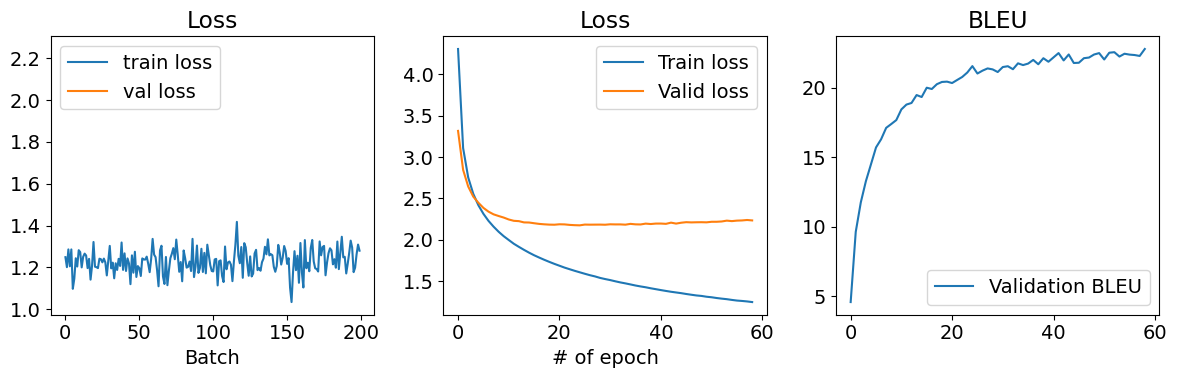

312it [00:14, 21.50it/s]


Epoch: 60 | Time: 0m 16s
	Train Loss: 1.239 | Train PPL:   3.452
	 Val. Loss: 2.236 |  Val. PPL:   9.359


In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model,
                       optimizer,
                       criterion,
                       CLIP,
                       None, n_show,
                       train_history,
                       valid_history,
                       bleu_scores)
    valid_loss = evaluate(model, val_loader, criterion)
    bleu_score, _1, _2 = calc_bleu(model, val_loader)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss and valid_loss < 2.3:
        best_valid_loss = valid_loss
        state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()}
        torch.save(state, save_file)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_scores.append(bleu_score)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')


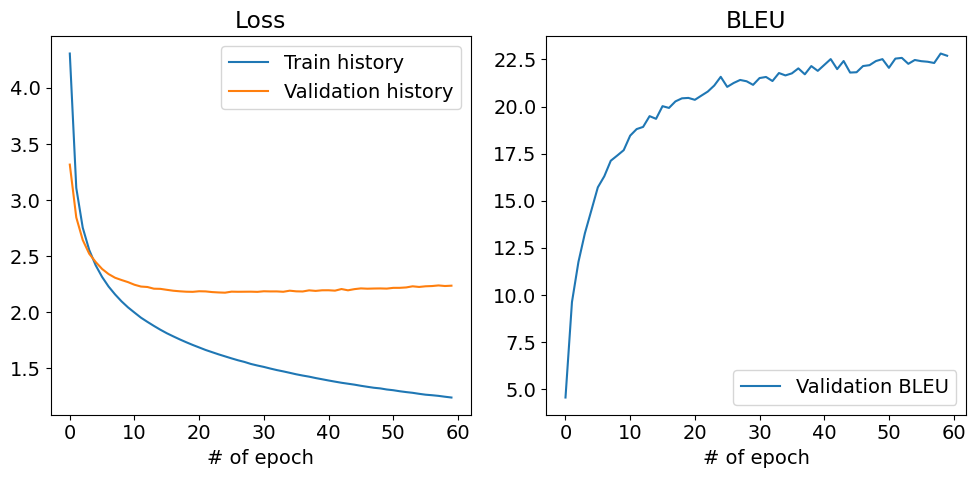

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(train_history, label='Train history')
ax[0].plot(valid_history, label='Validation history')
ax[0].set_xlabel('# of epoch')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(bleu_scores, label='Validation BLEU')
ax[1].set_xlabel('# of epoch')
ax[1].set_title('BLEU')
ax[1].legend()
fig.tight_layout()
plt.show()

In [ ]:
test_loss = evaluate(model, test_loader, criterion)
print('Test loss:', test_loss)

Test loss: 2.2249029435609518


In [ ]:
# Calculate BLEU score
bleu_score, translated_sentences, target_sentences = calc_bleu(model, test_loader)
print("BLEU Score:", bleu_score)

BLEU Score: 22.907607178682955


# Часть 2.

Добавил к базовой моделе learning rate scheduler. Выбрал StepLR.

Пробовал разный decay. Старался выбирать так, чтобы к концу 60-и эпох lr был на порядок меньше. Если брать decay еще меньше этого, то в конце модель уже очень медленно обучалась.

Также начальный lr сделал 0.002, чтобы в начале обучения модель быстрее обучалась.

ИТОГ:

Достиг BLEU на валидационной выборке 22.9.

В данном случае использование шедьюлера не дало никакого улучшения BLEU по сравнению с базовой моделью. Однако, он позволил несколько уменьшить флуктуации BLEU во время обучения. Кроме того, для юолее больших моделей он может улучшить обучение на последних этапах, поэтому в других моделях я его оставил.

In [ ]:
I += 1

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
CLIP = 1.0

lr = 0.002
lr_decay = 0.97
lr_step_size = 300

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(encoder, decoder).to(DEVICE)
print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_decay)

The model has 7,569,812 trainable parameters


In [ ]:
n_show = 200
N_EPOCHS = 60
save_file = SAVE_DIR + f'model_{I}.pt'

best_valid_loss = float('inf')

train_history = []
valid_history = []
bleu_scores = []

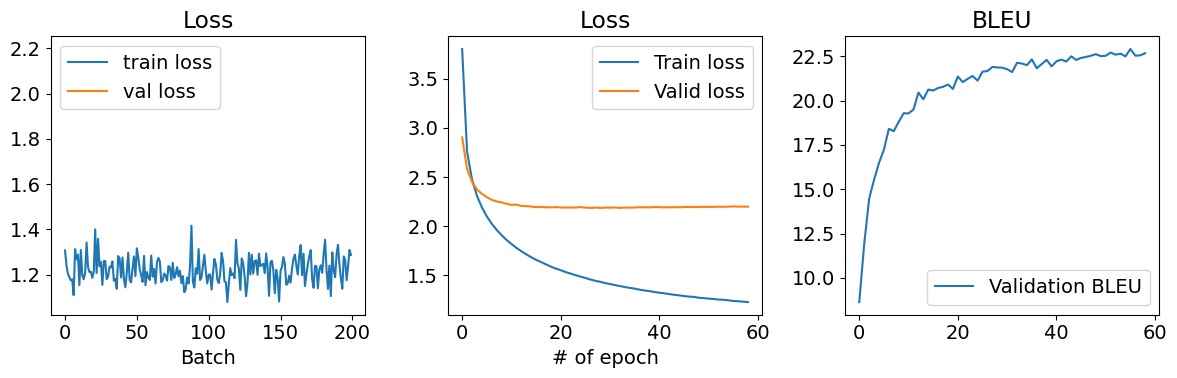

312it [00:14, 21.74it/s]


Epoch: 60 | Time: 0m 16s
	Train Loss: 1.224 | Train PPL:   3.401
	 Val. Loss: 2.198 |  Val. PPL:   9.007


In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model,
                       optimizer,
                       criterion,
                       CLIP,
                       lr_scheduler,
                       n_show,
                       train_history,
                       valid_history,
                       bleu_scores)
    valid_loss = evaluate(model, val_loader, criterion)
    bleu_score, _1, _2 = calc_bleu(model, val_loader)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss and valid_loss < 2.3:
        best_valid_loss = valid_loss
        state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()}
        torch.save(state, save_file)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_scores.append(bleu_score)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')


In [ ]:
lr_scheduler.get_last_lr()

[0.00030260598976480284]

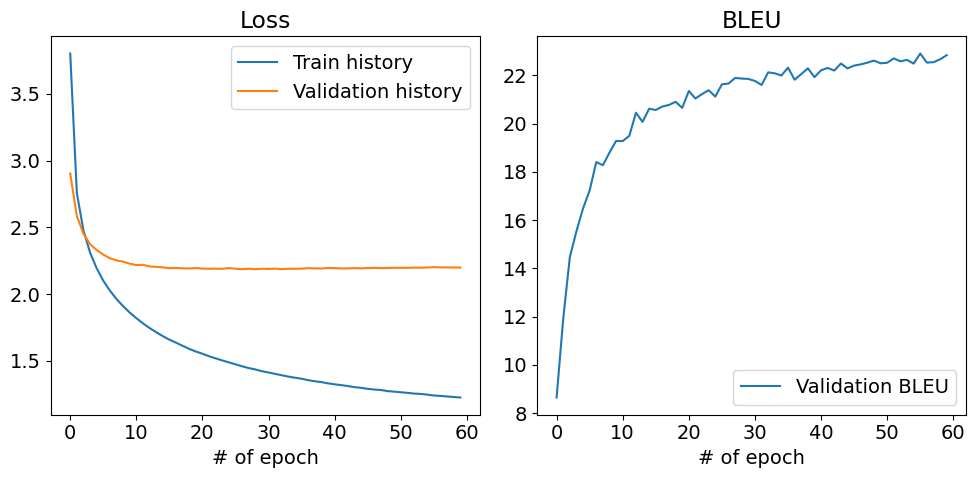

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(train_history, label='Train history')
ax[0].plot(valid_history, label='Validation history')
ax[0].set_xlabel('# of epoch')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(bleu_scores, label='Validation BLEU')
ax[1].set_xlabel('# of epoch')
ax[1].set_title('BLEU')
ax[1].legend()
fig.tight_layout()
plt.show()

In [ ]:
test_loss = evaluate(model, test_loader, criterion)
print('Test loss:', test_loss)

Test loss: 2.1853336346776864


In [ ]:
# Calculate BLEU score
bleu_score, translated_sentences, target_sentences = calc_bleu(model, test_loader)
print("BLEU Score:", bleu_score)

BLEU Score: 22.933780776704992


# Часть 3: реализация sqequence to sequence модели с механизмом внимания.

В данном ноутбуке приведена реализация sqequence to sequence модели с механизмом внимания. Использовалась модель внимания предложенная Bahdanau et al. в работе Neural Machine Translation by Jointly Learning to Align and Translate.

Для создания словаря использовался теокенизатор по словам и пунктуации (nltk.tokenize.wordpunct_tokenize). Для попадания в словарь слово должно встретиться в корпусе хотя бы 3 раза.

Был проведен подбор гиперпараметров. Наилучшим образом себя показала модель с гиперпараметрами: размер эмбедингов 256, размер скрытого слоя 512, однослойная GRU, дропаут 0.5. В моделе порядка 12M параметров. Модель обучалась 15 эпох. Обучение одной эпохи занимало околок пол минуты.

Более большие модели показывали большую склонность к переобучению, а более маленькие модели давали большой лосс.

Начальный lr взят 0.001. Также при обучении спользовался шедьюлер StepLR, который каждые 300 шагов понижал в 0.91 раз lr. Пробовал брать коэффициент понижения lr меньше, но тогда на поздних этапах при маленьком lr модель обучалась хуже и показывала меньшее BLEU на валидационной выборке.

ИТОГИ:

После подбора всех гиперпараметров итоговая модель дала BLEU на тестовой выборке 29.1.

В сравнении с базовой моделью произошло сильное увеличение качества. Однако, такая модель обучается в 2 раза дольше.

Сравнение с трансформером дано ниже в Части 4.

## Определение классов модели

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True,
                          num_layers=n_layers, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded)
        return output, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        query = query.unsqueeze(0).permute(1, 0, 2)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context

In [ ]:
class AttnDecoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.attention = Attention(hidden_size)
        self.rnn = nn.GRU(embedding_size + hidden_size, hidden_size, batch_first=True,
                          num_layers=n_layers, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        context = self.attention(hidden[-1], encoder_outputs)
        input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output)
        return output, hidden

In [ ]:
class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(AttnSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input, target_tensor=None):
        encoder_outputs, encoder_hidden = self.encoder(input)

        seq_length = MAX_SEQUENCE_LENGTH
        if target_tensor is not None:
            seq_length = target_tensor.shape[1]

        decoder_input = torch.empty(input.shape[0], 1, dtype=torch.long, device=DEVICE).fill_(SOS_IDX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(1, seq_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

In [ ]:
I += 1

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

lr = 0.001


encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = AttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, OUTPUT_DIM, N_LAYERS, DEC_DROPOUT)

model = AttnSeq2Seq(encoder, decoder).to(DEVICE)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,461,973 trainable parameters


/opt/calculation/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
n_show = 200
N_EPOCHS = 15
CLIP = 1.0
save_file = SAVE_DIR + f'model_{I}.pt'

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler = StepLR(optimizer, step_size=300, gamma=0.91)

best_valid_loss = float('inf')

train_history = []
valid_history = []
bleu_scores = []

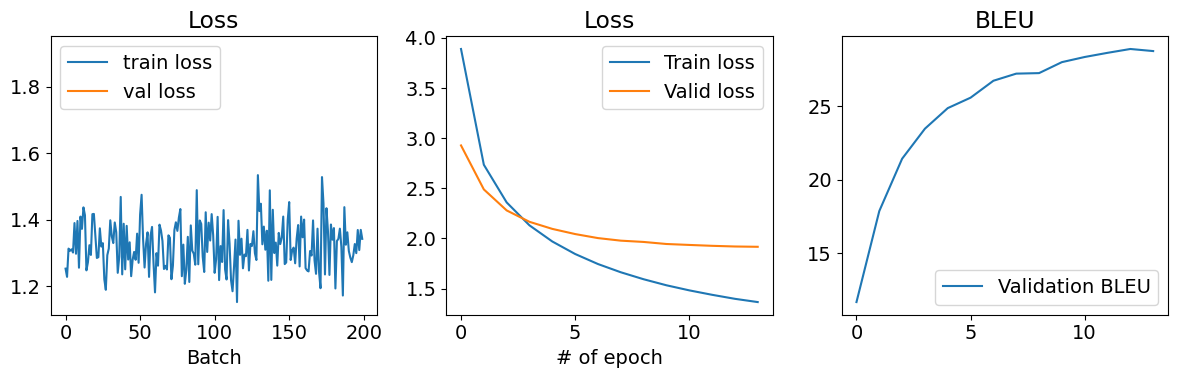

312it [00:27, 11.29it/s]


Epoch: 15 | Time: 0m 31s
	Train Loss: 1.333 | Train PPL:   3.792
	 Val. Loss: 1.909 |  Val. PPL:   6.748


In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model,
                       optimizer,
                       criterion,
                       CLIP,
                       lr_scheduler,
                       n_show,
                       train_history,
                       valid_history,
                       bleu_scores)
    valid_loss = evaluate(model, val_loader, criterion)
    bleu_score, _1, _2 = calc_bleu(model, val_loader)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss and valid_loss < 2.2:
        best_valid_loss = valid_loss
        state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()}
        torch.save(state, save_file)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_scores.append(bleu_score)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')


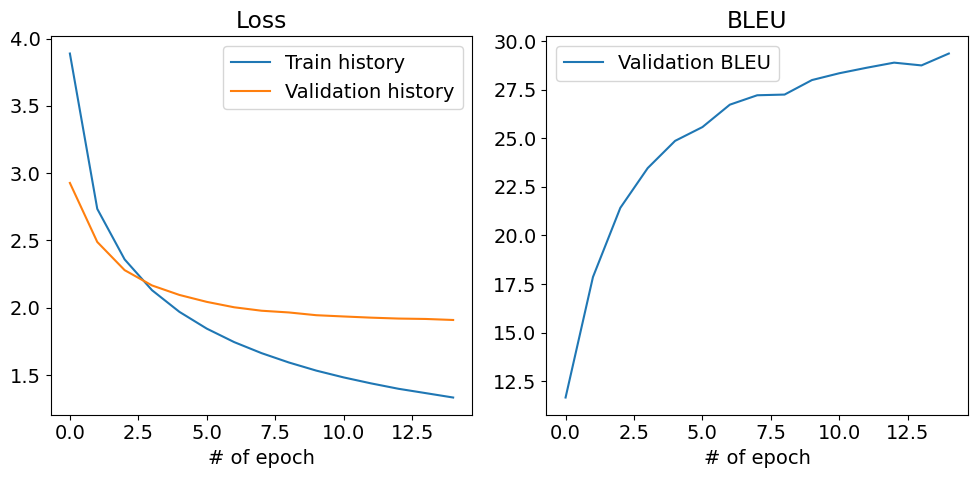

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(train_history, label='Train history')
ax[0].plot(valid_history, label='Validation history')
ax[0].set_xlabel('# of epoch')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(bleu_scores, label='Validation BLEU')
ax[1].set_xlabel('# of epoch')
ax[1].set_title('BLEU')
ax[1].legend()
fig.tight_layout()
plt.show()

In [ ]:
test_loss = evaluate(model, test_loader, criterion)
print('Test loss:', test_loss)

Test loss: 1.9044954149346602


In [ ]:
# Calculate BLEU score
bleu_score, translated_sentences, target_sentences = calc_bleu(model, test_loader)
print("BLEU Score:", bleu_score)

BLEU Score: 29.081800475520183


# Часть 4: Трансформер.

В данном ноутбуке приведена реализация трансформера. За основу взят модуль nn.Transformer.

Для создания словаря опять использовался теокенизатор по словам и пунктуации (nltk.tokenize.wordpunct_tokenize). Для попадания в словарь слово должно встретиться в корпусе хотя бы 3 раза.

Я проводил подбор гиперпараметров. Получилось, что в данной задаче наилучшим образом себя показывает небольшой трансформер. Большие модели слишком долго обучаются и при этом имеют склонность к переобучению.

Остановился на размере эмбединга 256, размер скрытого слоя в FFN 512, кол-во энкодеров и декодеров 3 и 3. Кол-во голов аттеншенна 4. Дропаут 0.1. В моделе порядка 11M параметров. Модель обучалась 15 эпох. Обучение одной эпохи занимало околок пол минуты. В конце 15 эпохи видно, что BLEU на валидационной выборке фактически перестала улучшать и вышла на плато.

Пробовал брать разные дропауты, для борбы с переобучением. Оказалось, что при дропауте 0.5 модель очень плохо и долго обучается. Поэтому дропаут старался брать маленьким (0.1-0.2).

Начальный lr взят 0.0002. При подборе lr набдюдал, что при больших значениях lr (больше 0.0004) модель сильно переобучается и validation loss получается сильно выше чем на трейне, который тоже оказывается не очень маленьким. Иными словами модель не может нормально обучаться с такими большими lr.

Также пробовал использовать различные learning rate schedulers. Шедьюлер из статьи Attention is all you nead плохо подошел для данной задачи. На практике в данной задаче оказалось, что для достаточно маленькой модели warmup должен быть коротким. А если он короткий, то потом lr очень быстро затухает, когда модель еще не успела нормально обучиться. Поэтому использовался обычный StepLR, который раз в 200 шагов понижает lr в заданное кол-во раз. Попробовав несколько коэфициентов, решил взять 0.92, при котором lr понижается не очень быстро.

ИТОГИ:

После подбора всех гиперпараметров итоговая модель трансформера дала BLEU на тестовой выборке 28.8.

В сравнении с Seq2Seq моделью с вниманием схожего размера трансформер показал себя примерно одинаково. AttnSeq2Seq дает BLEU 29.1, а трансформер 28.8. Различие минимальное и при более тщательном подборе гиперпараметров BLEU можно увеличить как для трансформера, так и для AttnSeq2Seq.

Обучение моделей такого размера также занимает примерно одинаковое время.

# Импортируем библиотеки

Изначально у меня трансформер был в отдельном ноутбуке, и для него был написан модифицировнный пайплайн, поэтому здесь идет как бы повторение.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, StepLR
from torch import Tensor

import torchtext
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.translate.bleu_score import corpus_bleu

import os
import tqdm
import numpy as np
import pandas as pd
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from timeit import default_timer as timer

/opt/calculation/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing



In [ ]:
torch.cuda.device_count()

2

In [ ]:
I = 0

path_to_data = '../data.txt'
MAX_SEQUENCE_LENGTH = 50
BATCH_SIZE = 128
SAVE_DIR = 'trans/'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

torch.manual_seed(42)

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [ ]:
ru_tokenizer = wordpunct_tokenize
en_tokenizer = wordpunct_tokenize

In [ ]:
# Step 1: Read the dataset file and parse it
def read_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    english_sentences = []
    russian_sentences = []
    for line in lines:
        english, russian = line.strip().split('\t')
        english_sentences.append(english)
        russian_sentences.append(russian)
    return english_sentences, russian_sentences

en_sentences, ru_sentences = read_dataset(path_to_data)

In [ ]:
print('Размер корпуса:', len(ru_sentences))

Размер корпуса: 50000


In [ ]:
# Step 2: Tokenize the sentences
def tokenize_sentences(sentences, tokenizer):
    tokenized_sentences = [tokenizer(sentence.lower()) for sentence in sentences]
    return tokenized_sentences

ru_tokenized = tokenize_sentences(ru_sentences, ru_tokenizer)
en_tokenized = tokenize_sentences(en_sentences, en_tokenizer)

In [ ]:
print(ru_tokenized[0])
print(en_tokenized[0])

['отель', 'cordelia', 'расположен', 'в', 'тбилиси', ',', 'в', '3', 'минутах', 'ходьбы', 'от', 'свято', '-', 'троицкого', 'собора', '.']
['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']


In [ ]:
# Step 3: Create vocabulary mappings
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    vocab = torchtext.vocab.vocab(counter, min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

ru_vocab = build_vocab(ru_tokenized)
en_vocab = build_vocab(en_tokenized)

In [ ]:
SRC_VOCAB_SIZE = len(ru_vocab)
TGT_VOCAB_SIZE = len(en_vocab)
PAD_IDX = en_vocab['<PAD>']
SOS_IDX = en_vocab['<SOS>']
EOS_IDX = en_vocab['<EOS>']
UNK_IDX = en_vocab['<UNK>']

In [ ]:
print(len(en_vocab))
print(len(ru_vocab))

7828
10799


In [ ]:
# Step 4: Transform data to torch Tensor and make train, val, test split
data = []
for (ru_sentence, en_sentence) in zip(ru_tokenized, en_tokenized):
    ru_tensor_ = torch.tensor(ru_vocab.lookup_indices(ru_sentence), dtype=torch.long)
    en_tensor_ = torch.tensor(en_vocab.lookup_indices(en_sentence), dtype=torch.long)
    data.append((ru_tensor_, en_tensor_))

train_size = int(0.8 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

In [ ]:
# Step 5: Make batches and data loaders
def generate_batch(data_batch):
    ru_batch, en_batch = [], []
    for (ru_item, en_item) in data_batch:
        ru_batch.append(torch.cat([torch.tensor([ru_vocab['<SOS>']]),
                                   ru_item,
                                   torch.tensor([ru_vocab['<EOS>']])
                                   ], dim=0))
        en_batch.append(torch.cat([torch.tensor([en_vocab['<SOS>']]),
                                   en_item,
                                   torch.tensor([en_vocab['<EOS>']])
                                   ], dim=0))
    ru_batch = pad_sequence(ru_batch, padding_value=ru_vocab['<PAD>'])
    en_batch = pad_sequence(en_batch, padding_value=en_vocab['<PAD>'])
    return ru_batch, en_batch


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [ ]:
batch = next(iter(train_loader))
print(batch[0].shape, batch[1].shape)

torch.Size([46, 128]) torch.Size([42, 128])


# Определение модели

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * np.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor, src_padding_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask,
                            src_key_padding_mask=src_padding_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor, memory_key_padding_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory, tgt_mask,
                          memory_key_padding_mask=memory_key_padding_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Дополнительные функции

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

def my_rate(step, lr_max=0.001, step_max=50):
    if step == 0:
        step = 1
    return lr_max * step_max**0.5 * min(step ** (-0.5), step * step_max**(-1.5))

In [ ]:
def train_epoch(model, optimizer, criterion, n_show = 50, if_scheduler=False,
                train_history=[], valid_history=[], bleu_history=[]):
    model.train()

    epoch_loss = 0
    I_val = []
    epoch_history = []
    val_history = []
    nf_val_history = []
    bleu_scores = []
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
        src = batch[0].to(DEVICE)
        tgt = batch[1].to(DEVICE)

        optimizer.zero_grad()

        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        if if_scheduler: lr_scheduler.step()

        epoch_history.append(loss.cpu().data.numpy())
        epoch_loss += loss.item()

        if (i+1) % n_show == 0:
            I_val.append(i)
            val_history.append(evaluate(model, val_loader, criterion))

            # bleu_score, _1, _2 = calc_bleu(model, val_loader)
            # bleu_scores.append(bleu_score)

            model.train()

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))

            line_11, = ax[0].plot(epoch_history, label='train loss')
            line_12, = ax[0].plot(I_val, val_history, label='val loss')
            # line_13, = ax[0].plot(I_val, nf_val_history, label='no force val loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Loss')
            ax[0].legend()

            # line_21, = ax[1].plot(I_val, bleu_scores, label='Validation BLEU')
            # ax[1].set_xlabel('Batch')
            # ax[1].set_title('BLEU')
            # ax[1].legend()

            if train_history != []:
                ax[1].plot(train_history, label='Train loss')
            if valid_history != []:
                ax[1].plot(valid_history, label='Valid loss')
            ax[1].legend()
            ax[1].set_xlabel('# of epoch')
            ax[1].set_title('Loss')

            if bleu_history != []:
                ax[2].plot(bleu_history, label='Validation BLEU' )
                ax[1].set_xlabel('# of epoch')
                ax[2].set_title('BLEU')
                ax[2].legend()


            clear_output(True)
            plt.show()

    return epoch_loss / len(list(train_loader))


def evaluate(model, loader, criterion):
    model.eval()
    losses = 0

    for src, tgt in loader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(loader))

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, src_padding_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask, src_padding_mask)
    ys = torch.ones(1, src.shape[1]).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask, src_padding_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)

        ys = torch.cat([ys, next_word.unsqueeze(0)], dim=0)
    return ys

In [ ]:
# Translate test data and get model translations
def calc_bleu(model, loader):
    translated_sentences = []
    target_sentences = []

    for batch in loader:
        model.eval()
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)

        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        src_padding_mask = (src == PAD_IDX).transpose(0, 1)

        with torch.no_grad():
            # Assuming your model returns token indices
            translated_indices = greedy_decode(model, src, src_mask, src_padding_mask,
                                               MAX_SEQUENCE_LENGTH, SOS_IDX)
            translated_indices = translated_indices.transpose(0, 1).cpu().tolist()

            for indices in translated_indices:
                tmp = []
                for idx in indices:
                    if idx == UNK_IDX or idx > 3:
                        tmp.append(en_vocab.lookup_token(idx))
                    elif idx == EOS_IDX:
                        break
                translated_sentences.append(tmp)

            trg_indices = trg.transpose(0, 1).cpu().tolist()
            for indices in trg_indices:
                tmp = []
                for idx in indices:
                    if idx == UNK_IDX or idx > 3:
                        tmp.append(en_vocab.lookup_token(idx))
                    elif idx == EOS_IDX:
                        break
                target_sentences.append(tmp)

    bleu_score = corpus_bleu([[text] for text in target_sentences], translated_sentences) * 100
    return bleu_score, translated_sentences, target_sentences

## Инициализация и обучение

In [ ]:
I += 1

EMB_SIZE = 256
NHEAD = 4
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT = 0.1

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROPOUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)
print(f'The model has {count_parameters(transformer):,} trainable parameters')

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

/opt/calculation/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


The model has 10,734,996 trainable parameters


In [ ]:
NUM_EPOCHS = 15
n_show = 100
if_scheduler = True
save_path = SAVE_DIR + f'tr_{I}.pt'

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9)

if if_scheduler:
    # lr_scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda step: my_rate(step, 0.0002, 2))

    lr_scheduler = StepLR(optimizer, step_size=200, gamma=0.92)

train_history = []
valid_history = []
bleu_scores = []

best_valid_loss = float('inf')

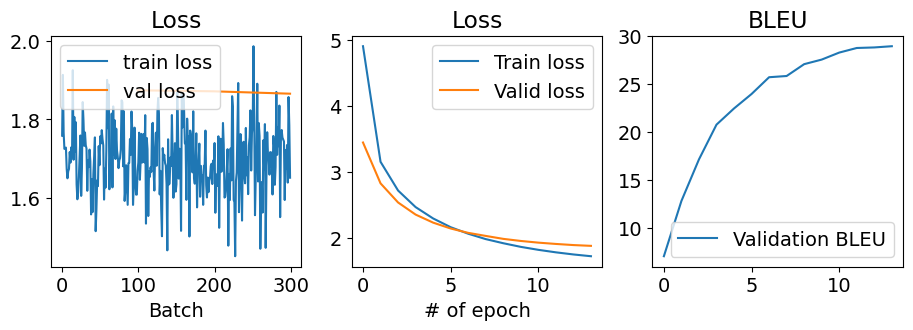

313it [00:11, 28.16it/s]


Epoch: 15, Train loss: 1.699, Val loss: 1.867,            Epoch time = 22.035s


In [ ]:
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer,
                             optimizer,
                             criterion,
                             n_show,
                             if_scheduler,
                             train_history,
                             valid_history,
                             bleu_scores)
    valid_loss = evaluate(transformer, val_loader, criterion)
    bleu_score, _1, _2 = calc_bleu(transformer, val_loader)
    end_time = timer()

    if valid_loss < best_valid_loss and valid_loss < 2.5:
        best_valid_loss = valid_loss
        state = {
                'epoch': epoch,
                'state_dict': transformer.state_dict(),
                'optimizer': optimizer.state_dict()}
        torch.save(state, save_path)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_scores.append(bleu_score)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, \
           "f"Epoch time = {(end_time - start_time):.3f}s"))


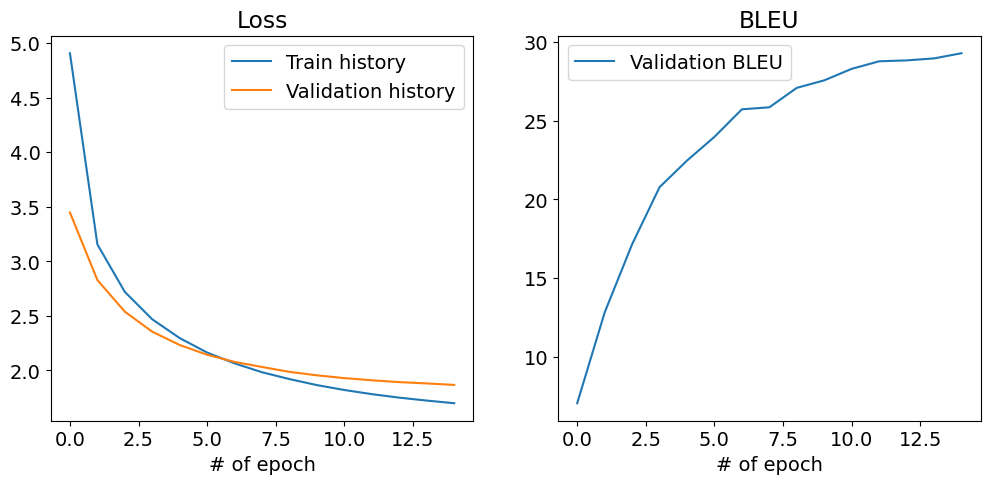

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].plot(train_history, label='Train history')
ax[0].plot(valid_history, label='Validation history')
ax[0].set_xlabel('# of epoch')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(bleu_scores, label='Validation BLEU')
ax[1].set_xlabel('# of epoch')
ax[1].set_title('BLEU')
plt.legend()

plt.show()

In [ ]:
# Calculate BLEU score
bleu_score, translated_sentences, target_sentences = calc_bleu(transformer, test_loader)
print("BLEU Score:", bleu_score)

BLEU Score: 28.78576073185496
